In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import time
import pickle
import pandas as pd
import numpy as np
import re
from datetime import datetime

# Project Lists

In [ ]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.ma   ximize_window()
# Extract link and project name
i = 1
while True:
    try:
        website = "https://cryptorank.io/funding-rounds?page={0}".format(i)
        
        driver.get(website)
        time.sleep(2)
        projects = driver.find_elements(By.XPATH,'//tr[@class="sc-7ff8d1ea-0 kuuWTw init-scroll"]')
        
        for project in projects:    
            name = project.find_element(By.TAG_NAME, "p").text
            token_sale_link = project.find_element(By.TAG_NAME, "a").get_attribute("href")
            overview_link = token_sale_link.replace("/ico/","/price/")
            
            data.append([name, overview_link, token_sale_link])
        i += 1
    except:
        break

df = pd.DataFrame(data, columns=['First Funding date', 'Overview', 'Token Sale'])
df['Name'] = df['Overview'].apply(lambda x: x.split("/")[-1]).apply(lambda x: x.split("#")[0]).apply(lambda x: x.replace("-", " ").title())

def convert_date(date_str):
    if len(date_str.split()) == 2:
        date_str += " 2024"
    try:
        dt = datetime.strptime(date_str, '%d %b %Y')
        return dt.strftime('%Y-%m-%d')
    except ValueError:
        return None

df['First Funding date'] = df['First Funding date'].apply(convert_date)
df.drop_duplicates().to_csv("project_lists.csv", index = False)

# Project Information

## Overview

In [ ]:
df = pd.read_csv("project_lists.csv")
df.head()

In [ ]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

# Extraction of link and project name ends here

services = []
total_raised_s = []
descriptions = []
links_s = []
name = []

for website in df['Overview'][:50]:
    crypto_name = website.split("/")[-1].split("#")[0].replace("_"," ").title()
    name.append(crypto_name)
    
    driver.get(website)
    time.sleep(5)
    service, total_raised, description, links = '', '', '', []
    try:
        service_element = driver.find_element(By.XPATH,'//a[starts-with(@href, "/categories/")]/p')
        services.append(service_element.text)
    except:
        # print(crypto_name," help1")
        pass
    try:
        total_raised_element = driver.find_element(By.XPATH,'//p[@class="sc-50f3633f-0 gsUEex"]')
        total_raised_s.append(total_raised_element.text)
    except:
        # print(crypto_name, " help2")
        pass
    try:
        description_element = driver.find_element(By.XPATH,'//div[@class="sc-50f3633f-0 sc-f084fb54-0 eEpKHS gQIZzl"]/p')
        descriptions.append(description_element.text)
    except:
        # print(crypto_name, " help3")
        pass
    
    
    ###########################
    
    try:
        button = driver.find_elements(By.XPATH,'//button[@class="sc-4e8da034-0 cHRla-d"]')
        for i in range(len(button)):
            driver.get(website)
            time.sleep(5)
            button = driver.find_elements(By.XPATH,'//button[@class="sc-4e8da034-0 cHRla-d"]')
            link = button[i]
            time.sleep(2)
            link.click()
            time.sleep(5)
            link_elements = driver.find_elements(By.XPATH,'//div[@class="sc-f30b0320-0 cAUFgN"]')
            heading = []
            some_links_text = []
            some_links = []
            for link_element in link_elements:
                some_links.append([i.get_attribute("href") for i in link_element.find_elements(By.TAG_NAME,"a")])
            links.append([some_links])
        links_s.append(links)
    except:
        # print(crypto_name, " help4")
        pass
    
    ############################

    time.sleep(10)
    print(len(name),len(services),len(total_raised_s),len(descriptions),len(links_s))

driver.quit()

In [ ]:
data = [name,services,total_raised_s,descriptions,links_s]
df_overview = pd.DataFrame(data).T
df_overview.columns = ["Crypto Name", "Service", "Total Raised", "Description", "Links"]
df_overview.head()
df_overview.to_csv("Overview_details.csv", index=False)

## Fundraising

In [ ]:
df = pd.read_csv("project_lists.csv")
df.head()

In [ ]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

data = []
for website in df['Token Sale'][:50]:
    crypto_name = website.split("/")[-1].split("#")[0].replace("_"," ").title()
    driver.get(website)
    item_elements = driver.find_elements(By.XPATH,'//div[@class="sc-e007581-0 sc-b608d829-0 kDrqot bslrEt"]')
    data.append([crypto_name,[div.text for div in item_elements]])
    time.sleep(5)

df_fundings = pd.DataFrame(data, columns = ["Name", "Funding Details"])
df_fundings.to_csv("Funding_details.csv", index=False)

driver.quit()

## Twitter

In [14]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

def get_link(lst):
    try:
        pattern = r'https://twitter\.com/[A-Za-z0-9_]+'
        return re.findall(pattern, lst)[0]
    except:
        return np.NaN

def get_followers(link):
    try:
        driver.get(link) 
        time.sleep(3)
        return driver.find_element(By.XPATH,'//a[contains(@href, "/verified_followers")]').text

    except:
        return np.NaN
        

df2 = pd.read_csv("../Data/Cleaned_Overview_Details.csv")
df2['twitter_link'] = df2['Links'].apply(get_link)
df2['followers'] = df2["twitter_link"].apply(get_followers)
driver.quit()

df2[["Crypto Name", "twitter_link", "followers"]].to_csv("../Data/Twitter_followers.csv", index=False)

,Crypto Name,Service,Total Raised,Description,Links,twitter_link,followers
0,Raiinmaker,Blockchain Service,300000.0,Raiinmaker is a project focused on acceleratin...,"[[[['https://cryptorank.io/blockchains/base'],...",https://twitter.com/Raiinmakerapp,70.2K Followers
1,Satoshisync,DeFi,NaN,SatoshiSync is The Permissionless Chain Agnost...,NaN,NaN,NaN
2,Legitimate,Blockchain Infrastructure,4300000.0,Legitimate presents an on-chain framework meti...,[[[['https://cryptorank.io/categories/blockcha...,https://twitter.com/legitimatetech,NaN
3,Mangata,Blockchain Infrastructure,10600000.0,Gasp offers native cross-chain swaps without r...,[[[['https://cryptorank.io/categories/blockcha...,https://twitter.com/gasp_xyz,49K Followers
4,Bonus-Block,Blockchain Service,NaN,BonusBlock is a Web3 marketing platform that i...,NaN,NaN,NaN
...,...,...,...,...,...,...,...
295,Startale-Labs,Blockchain Infrastructure,7000000.0,Startale Labs is a web3 tech company developin...,"[[[['https://startale.org/', 'https://twitter....",https://twitter.com/startalehq,NaN
296,Lends,DeFi,NaN,Cross-chain lending solution with access to th...,NaN,NaN,NaN
297,Carry-1St,GameFi,55500000.0,NaN,[[[['https://cryptorank.io/categories/gamefi']...,https://twitter.com/carry1st,NaN
298,Kodiakfi,DeFi,2000000.0,Kodiak is a foundational building block for li...,"[[[['https://cryptorank.io/categories/defi'], ...",https://twitter.com/KodiakFi,NaN


In [55]:
df2  = pd.read_csv("../Data/data.csv")
df2.shape

(324, 15)

In [40]:
def followers_to_number(followers_str):
    try:
        return float(followers_str.replace("Followers","").replace('K', 'e3').replace('M', 'e6').replace('B', 'e9'))
    except:
        return np.NaN

# Example usage
followers_count = "NaN"
numeric_followers = followers_to_number(followers_count)
print(numeric_followers)

nan


In [51]:
df2["followers"].apply(followers_to_number)

0      70200.0
1          NaN
2          NaN
3      49000.0
4          NaN
        ...   
295        NaN
296        NaN
297        NaN
298    68300.0
299        NaN
Name: followers, Length: 300, dtype: float64

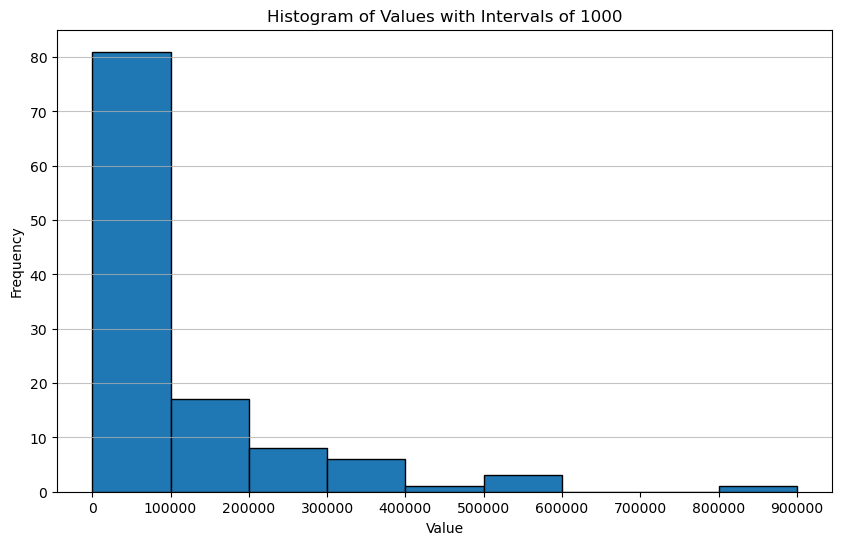

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
data = {'Value': df2["followers"].apply(followers_to_number).dropna().astype(int).to_list()}
df = pd.DataFrame(data)

abc= 100000
bins = range(0, df['Value'].max() + abc, abc)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['Value'], bins=bins, edgecolor='black')
plt.xticks(bins)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values with Intervals of 1000')
plt.grid(axis='y', alpha=0.75)
plt.show()
